In [36]:
# install necessary dependencies
!pip install pandas sqlalchemy pymysql

DATA EXTRACTION

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

def create_connection(host, port, database, username, password):
    engine = None
    try:
        engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')
        return engine
    except Exception as e:
        print(e)

username = 'report_user'
password = 'Report!123'
host = 'mksol.vn'
port = '3306'
database = 'sakai'

engine = create_connection(host, port, database, username, password)

sql = 'SELECT * FROM view_mosquito_name_au_year_month_day_sitecode_duration'

df = pd.read_sql(sql, engine)

df.to_csv("detect_image_services.csv", index = False)

print(df.head())

        date  year  month  day sitecode_cd       createdby_username  \
0 2025-05-15  2025      5   15        None  mosquitoes.id@gmail.com   
1 2025-05-15  2025      5   15        None  mosquitoes.id@gmail.com   
2 2025-05-15  2025      5   15        None  mosquitoes.id@gmail.com   
3 2025-05-15  2025      5   15        None  mosquitoes.id@gmail.com   
4 2025-05-15  2025      5   15        None  mosquitoes.id@gmail.com   

                    photos              state        city region  \
0  20250517-062259-878.jpg  Western Australia  Harrisdale   None   
1  20250517-062332-312.jpg  Western Australia  Harrisdale   None   
2  20250517-062335-355.jpg  Western Australia  Harrisdale   None   
3  20250517-062337-744.jpg  Western Australia  Harrisdale   None   
4  20250517-062345-737.jpg  Western Australia  Harrisdale   None   

          subregion lga           detected_name  duration  
0  City of Armadale      Culex quinquefasciatus      2420  
1  City of Armadale      Culex quinquefascia

1. Data Preparation and Cleaning

In [38]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

# Convert duration to numeric (optional if it already is)
df['duration'] = pd.to_numeric(df['duration'], errors = 'coerce')

# clean column names: lowercase and underscores
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# check for null values
print(df.isnull().sum())


date                      0
year                      0
month                     0
day                       0
sitecode_cd            1317
createdby_username        0
photos                    0
state                     0
city                      0
region                34978
subregion                 0
lga                       0
detected_name             0
duration                  0
dtype: int64


So it seems that region has a LOT of null values and it might not be useful so we can drop it.

In [39]:
# Drop the region column since it's almost entirely null

df.drop(columns = ['region'], inplace = True)


2. SERVICE METRICS

First, we will make a function to calculate this for us.

In [40]:
def calculate_service_metrics(df):
    try:
        # group data by user
        grouped = df.groupby('createdby_username').agg(
            total_images = ('photos', 'count'),
            total_duration_ms = ('duration', 'sum')
        ).reset_index()

        # Calculate revenue, cost, and margin
        grouped['revenue_aud'] = grouped['total_images'] / 10
        grouped['cost_aud'] = (grouped['total_duration_ms'] / 10000) * 0.25
        grouped['margin_aud'] = grouped['revenue_aud'] - grouped['cost_aud']

        return grouped.sort_values(by = 'revenue_aud', ascending = False)
    
    except Exception as e:
        print("Error calculating service metrics: ", e)
        return pd.DataFrame() # return empty if error

In [41]:
# Using our service metrics calculator function
metrics_df = calculate_service_metrics(df)
print(metrics_df.head())

        createdby_username  total_images  total_duration_ms  revenue_aud  \
2  van.chung2407@gmail.com         34667         2908396648       3466.7   
1        thachln@gmail.com           226            2463196         22.6   
0  mosquitoes.id@gmail.com            85             236180          8.5   

     cost_aud  margin_aud  
2  72709.9162 -69243.2162  
1     61.5799    -38.9799  
0      5.9045      2.5955  


3. Top-Level Insights

In [42]:
# Most active users
print("=== TABLE FOR MOST ACTIVE USERS ===\n")
top_users = df['createdby_username'].value_counts().reset_index()
top_users.columns = ['username', 'image_count']
print(top_users.head())

# Most common mosquito species
print("\n\n=== TABLE FOR MOST COMMON MOSQUITO SPECIES ===\n")
top_species = df['detected_name'].value_counts().reset_index()
top_species.columns = ['species', 'count']
print(top_species.head())

# daily and monthly image trends
print("\n\n=== TABLE FOR DAILY AND MONTHLY IMAGE TRENDS ===")
daily_trend = df.groupby('date').size().reset_index(name = 'image_count')
print(daily_trend.head())

monthly_trend = df.groupby(['year', 'month']).size().reset_index(name = 'image_count')
monthly_trend['year_month'] = pd.to_datetime(monthly_trend[['year', 'month']].assign(day = 1))
print(monthly_trend.head())


=== TABLE FOR MOST ACTIVE USERS ===

                  username  image_count
0  van.chung2407@gmail.com        34667
1        thachln@gmail.com          226
2  mosquitoes.id@gmail.com           85


=== TABLE FOR MOST COMMON MOSQUITO SPECIES ===

                  species  count
0           Aedes vigilax  22599
1     Culex annulirostris   5013
2      Aedes notoscriptus   2582
3  Culex quinquefasciatus   1878
4     Anopheles annulipes   1374


=== TABLE FOR DAILY AND MONTHLY IMAGE TRENDS ===
        date  image_count
0 2024-11-19          329
1 2024-12-06          571
2 2024-12-17         1123
3 2024-12-18         5207
4 2024-12-21          589
   year  month  image_count year_month
0  2024     11          329 2024-11-01
1  2024     12         7490 2024-12-01
2  2025      1        13825 2025-01-01
3  2025      2        11622 2025-02-01
4  2025      3          823 2025-03-01


I want to save some data we found so we have an easier time charting later.

In [43]:
top_users.to_csv("top_users.csv", index=False)            # csv file for top users
top_species.to_csv("top_species.csv", index=False)        # csv file for top species
daily_trend.to_csv("daily_trend.csv", index=False)        # csv file for daily trend
monthly_trend.to_csv("monthly_trend.csv", index=False)    # csv file for monthly trend

4. GEOGRAPHIC SALES ANALYSIS

Group and Summarize detection volume and revenue

In [44]:
# group data by state, city, and subregion, and calculate:
# image count, total processing duration, revenue, cost, and margin
def geo_sales_summary(df):
    grouped = df.groupby(['state', 'city', 'subregion']).agg(
        image_count = ('photos', 'count'),            # count images per geographic region
        total_duration_ms = ('duration', 'sum')       # sum durations for cost calc
    ).reset_index()

    # calculate financials
    grouped['revenue_aud'] = grouped['image_count'] / 10
    grouped['cost_aud'] = (grouped['total_duration_ms'] / 10000) * 0.25
    grouped['margin_aud'] = grouped['revenue_aud'] - grouped['cost_aud']

    return grouped

Summary Table

In [45]:
# Generate the geographic summary table
geo_summary_df = geo_sales_summary(df)

# Save for plotting or reporting
geo_summary_df.to_csv("geo_summary_flat.csv", index=False)

# Preview the result
print(geo_summary_df.head())

               state        city           subregion  image_count  \
0           Victoria   Melbourne                               10   
1  Western Australia                City of Armadale          132   
2  Western Australia    Armadale    City of Armadale         4954   
3  Western Australia    Ashfield  Town of Bassendean         1067   
4  Western Australia  Bassendean          Bassendean          329   

   total_duration_ms  revenue_aud     cost_aud   margin_aud  
0              21100          1.0     0.527500     0.472500  
1             311071         13.2     7.776775     5.423225  
2          183148342        495.4  4578.708550 -4083.308550  
3           52546110        106.7  1313.652750 -1206.952750  
4           11114278         32.9   277.856950  -244.956950  


Hierarchical Tree Function

In [46]:
from collections import defaultdict

def build_geo_tree(df):
    """
    Construct a nested dictionary:
    state to city to subregion to metrics
    where metrics include image count, revenue, and margin.
    """
    # Initialize 3-level nested dictionary using defaultdict
    tree = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    # Iterate through each row to populate tree
    for _, row in df.iterrows():
        state = row['state']
        city = row['city']
        subregion = row['subregion']

        # Assign metrics to the nested structure
        tree[state][city][subregion] = {
            'image_count': row['image_count'],
            'revenue_aud': row['revenue_aud'],
            'margin_aud': row['margin_aud']
        }

    return dict(tree)  # Convert back to regular dict for export/use

In [47]:
geo_tree = build_geo_tree(geo_summary_df)

# Save for plotting or reporting
geo_summary_df.to_csv("geo_summary_flat.csv", index=False)

# Preview the result
print(geo_summary_df.head())

               state        city           subregion  image_count  \
0           Victoria   Melbourne                               10   
1  Western Australia                City of Armadale          132   
2  Western Australia    Armadale    City of Armadale         4954   
3  Western Australia    Ashfield  Town of Bassendean         1067   
4  Western Australia  Bassendean          Bassendean          329   

   total_duration_ms  revenue_aud     cost_aud   margin_aud  
0              21100          1.0     0.527500     0.472500  
1             311071         13.2     7.776775     5.423225  
2          183148342        495.4  4578.708550 -4083.308550  
3           52546110        106.7  1313.652750 -1206.952750  
4           11114278         32.9   277.856950  -244.956950  


Stacked Bar Chart

In [48]:
!pip install seaborn
!pip install matplotlib

import seaborn as sns
import matplotlib.pyplot as plt

state
Western Australia    34968
Victoria                10
Name: count, dtype: int64


C:\Users\KaikiI\AppData\Local\Temp\ipykernel_25212\3204107410.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='total_revenue', y='state', palette='Blues_d')


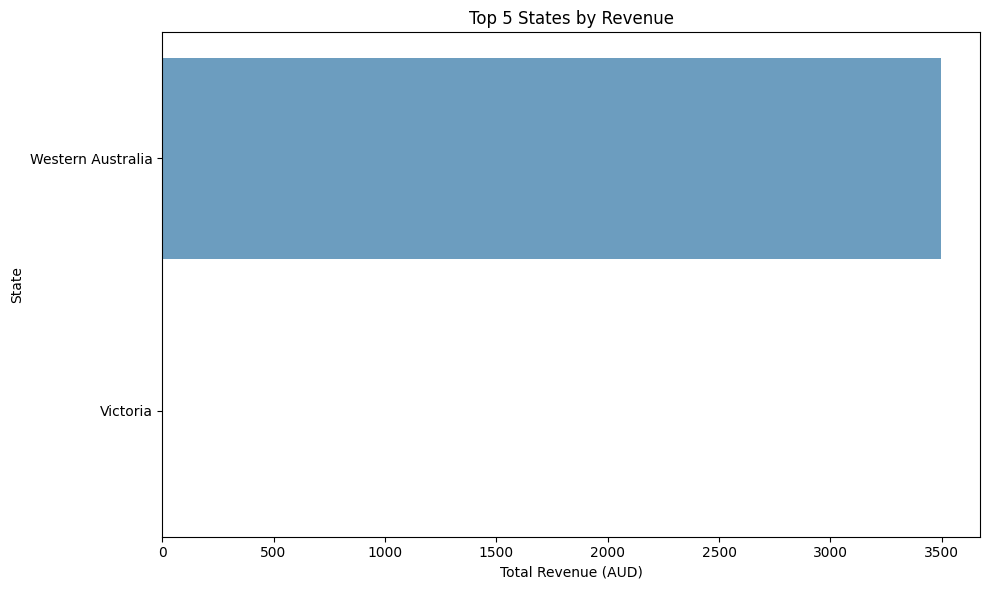

In [49]:
# group Revenue by state and get top 5
top_states = geo_summary_df.groupby('state').agg(
    total_revenue = ('revenue_aud', 'sum')
).sort_values('total_revenue', ascending = False).head(5).reset_index()

print(df['state'].value_counts()) # so we can see Victoria's value
#PLOT
plt.figure(figsize = (10, 6))
sns.barplot(data=top_states, x='total_revenue', y='state', palette='Blues_d')
plt.title('Top 5 States by Revenue')
plt.xlabel('Total Revenue (AUD)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

Heatmap: Revenue or detection volume by city and subregion

In [50]:
# creating a pivot table for heatmap

pivot_heatmap = geo_summary_df.pivot_table(
    index = 'subregion',
    columns = 'city',
    values='revenue_aud',
    aggfunc='sum',
    fill_value=0
)

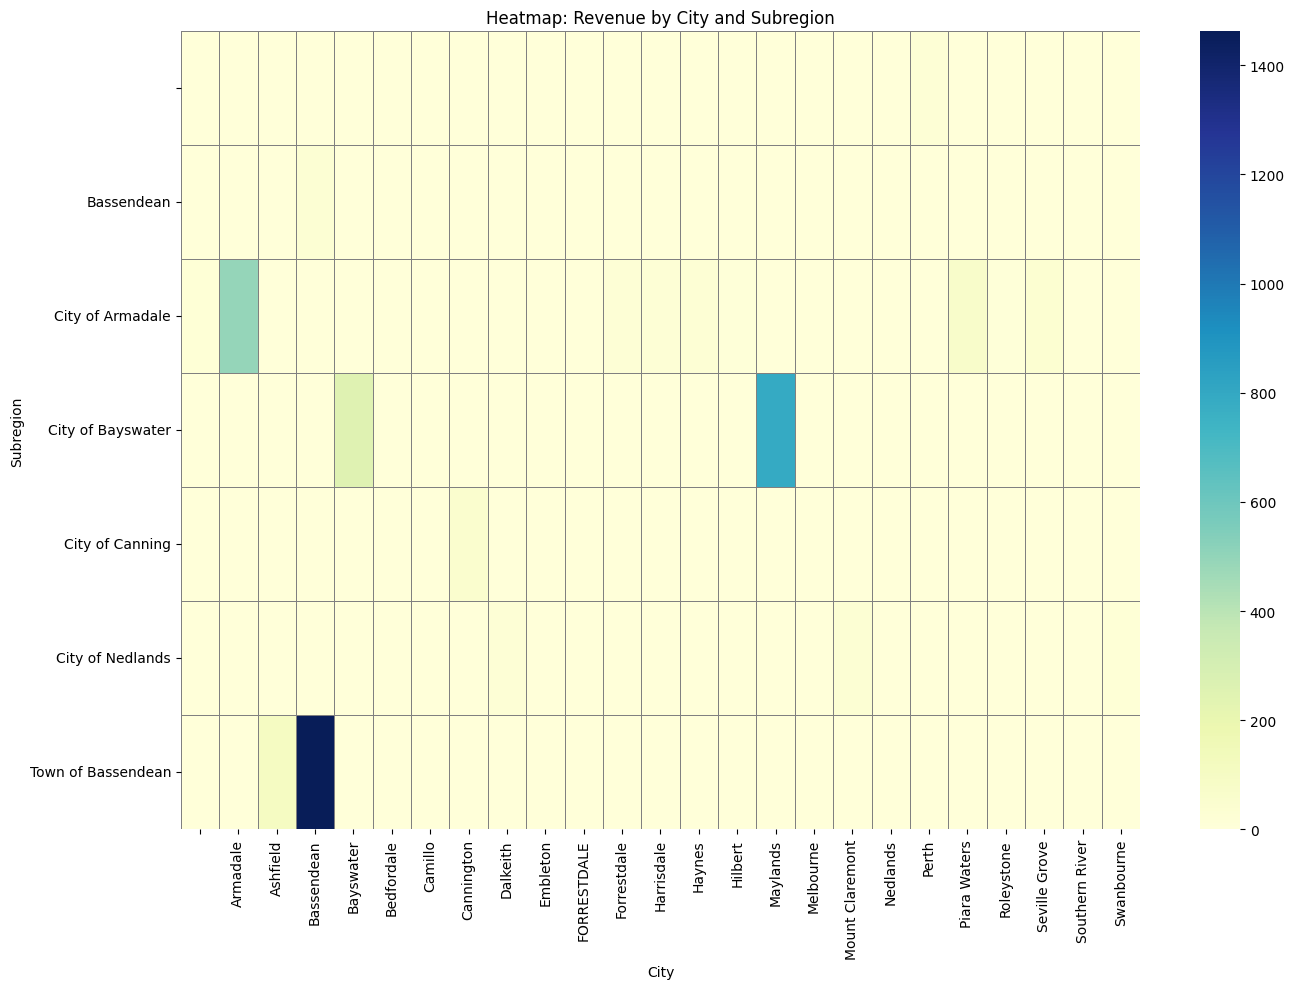

In [51]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    pivot_heatmap,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    annot=False  # set to True if you want exact values shown
)

plt.title('Heatmap: Revenue by City and Subregion')
plt.xlabel('City')
plt.ylabel('Subregion')
plt.tight_layout()
plt.show()

5. Visualizations (Matplotlib & Seaborn)

Bar Chart: Top 5 users by revenue

C:\Users\KaikiI\AppData\Local\Temp\ipykernel_25212\3652124445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x='revenue_aud', y='createdby_username', palette='viridis')


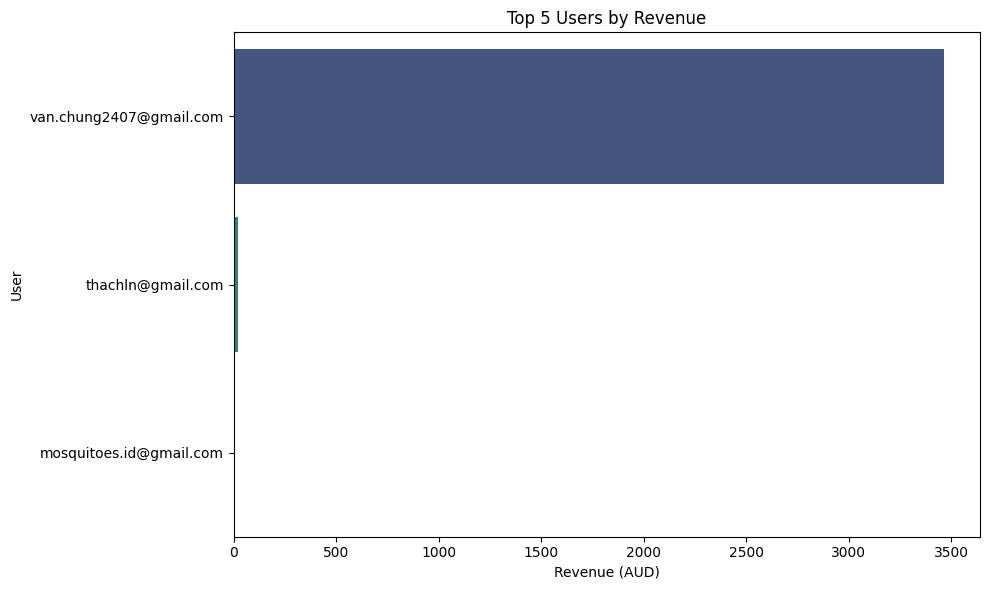

In [52]:
# sort and take top 5 users by revenue
top_users = metrics_df.sort_values(by='revenue_aud', ascending=False).head(5)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_users, x='revenue_aud', y='createdby_username', palette='viridis')
plt.title('Top 5 Users by Revenue')
plt.xlabel('Revenue (AUD)')
plt.ylabel('User')
plt.tight_layout()
plt.show()

Pie Chart: Species Distribution

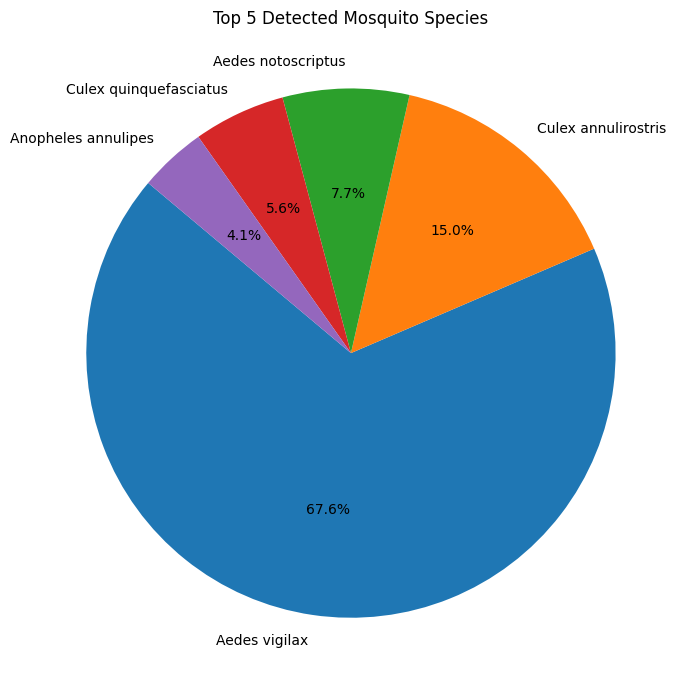

In [53]:
# Count top 5 species
top_species = df['detected_name'].value_counts().head(5)

# Plot
plt.figure(figsize=(7, 7))
plt.pie(top_species, labels=top_species.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Detected Mosquito Species')
plt.axis('equal')  # make it a circle
plt.tight_layout()
plt.show()


Line Chart: Daily number of detections

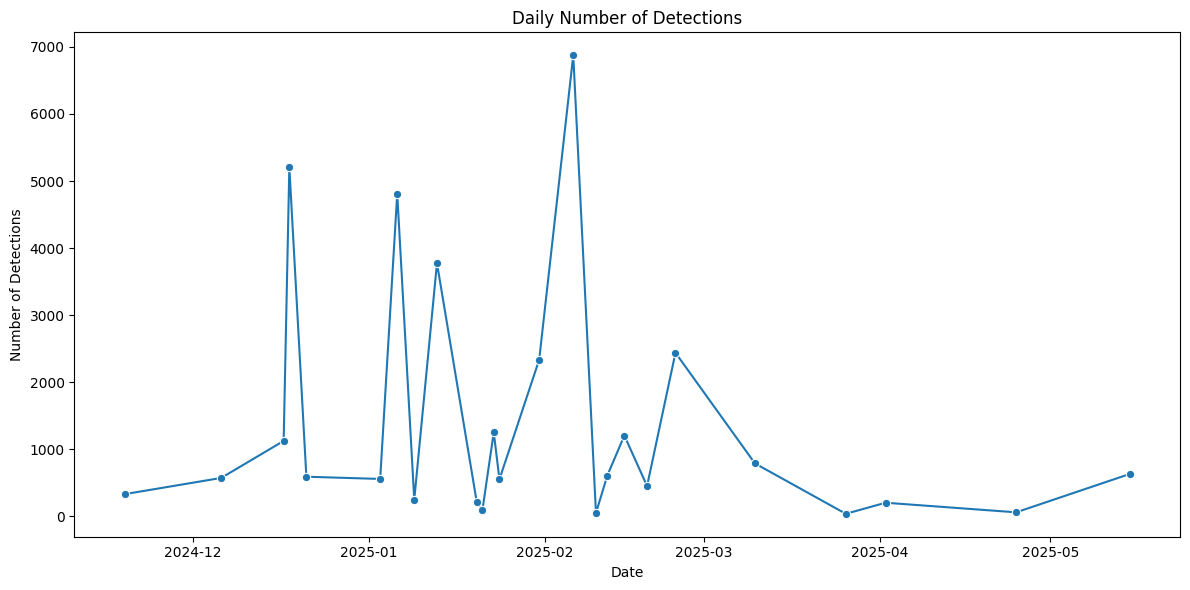

In [54]:
# Group by date
daily_trend = df.groupby('date').size().reset_index(name='detections')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_trend, x='date', y='detections', marker='o')
plt.title('Daily Number of Detections')
plt.xlabel('Date')
plt.ylabel('Number of Detections')
plt.tight_layout()
plt.show()


Tree Chart / grouped bar chart: State to City to Subregion analysis

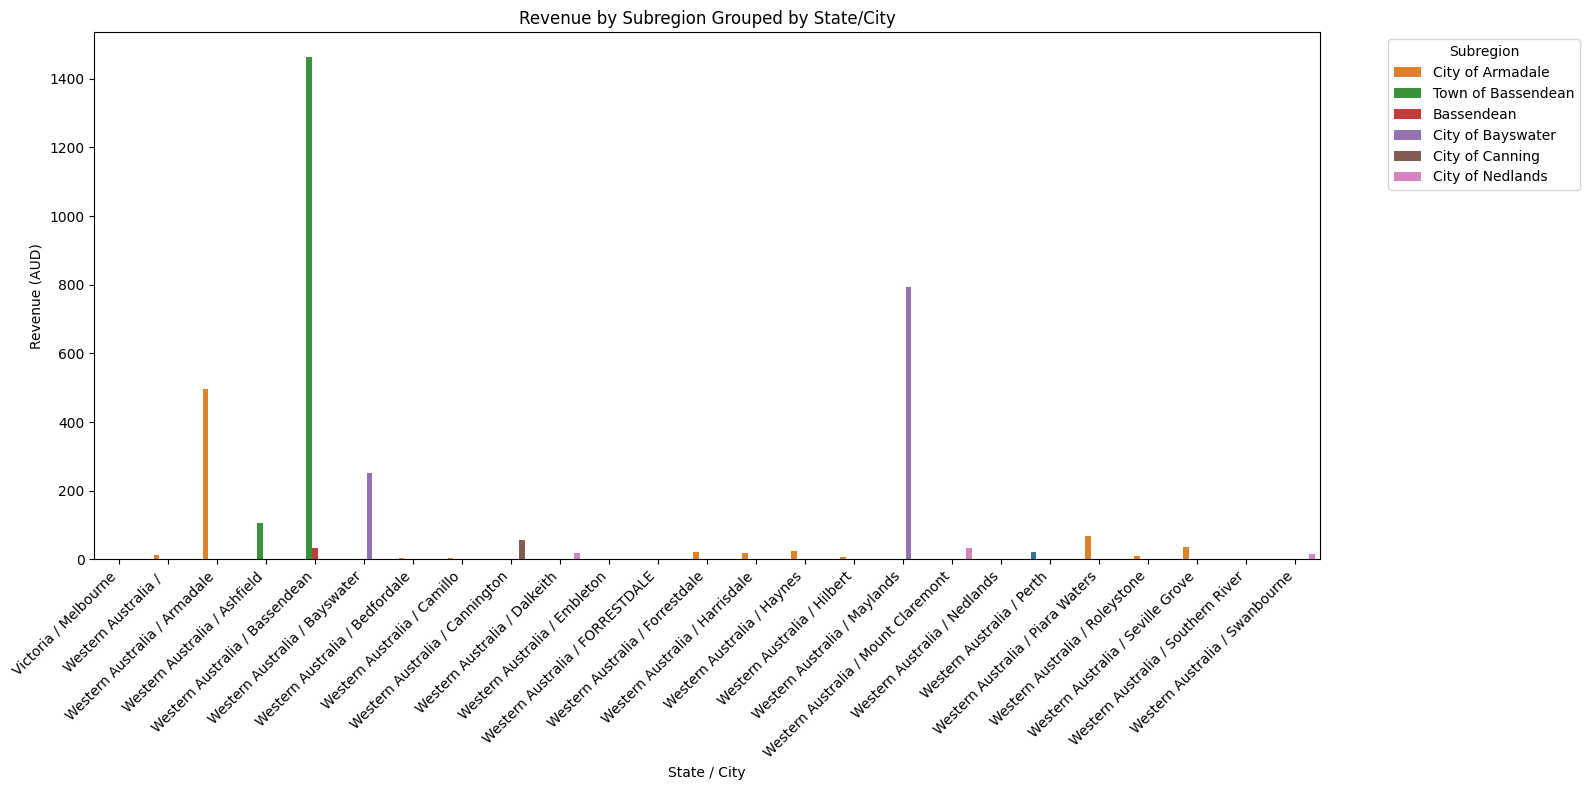

In [55]:
# We'll use state + city as x-axis, and subregion as hue
grouped_bar = geo_summary_df.copy()
grouped_bar['state_city'] = grouped_bar['state'] + ' / ' + grouped_bar['city']

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=grouped_bar, x='state_city', y='revenue_aud', hue='subregion')
plt.title('Revenue by Subregion Grouped by State/City')
plt.xlabel('State / City')
plt.ylabel('Revenue (AUD)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subregion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Advanced #1 new requests (not required)

Descriptive Statistics

In [56]:
# Descriptive stats on geo-level financials
print(geo_summary_df[['image_count', 'total_duration_ms', 'revenue_aud', 'cost_aud', 'margin_aud']].describe())


        image_count  total_duration_ms  revenue_aud      cost_aud  \
count     26.000000       2.600000e+01    26.000000     26.000000   
mean    1345.307692       1.119652e+08   134.530769   2799.130792   
std     3244.816651       3.982713e+08   324.481665   9956.783345   
min        2.000000       3.220000e+02     0.200000      0.008050   
25%       47.500000       1.198780e+05     4.750000      2.996950   
50%      202.000000       1.036060e+06    20.200000     25.901513   
75%      519.250000       4.494821e+06    51.925000    112.370531   
max    14623.000000       1.982263e+09  1462.300000  49556.580175   

         margin_aud  
count     26.000000  
mean   -2664.600023  
std     9648.446918  
min   -48094.280175  
25%      -68.114544  
50%       -6.551513  
75%        1.203281  
max       10.565550  


Correlation Matrix

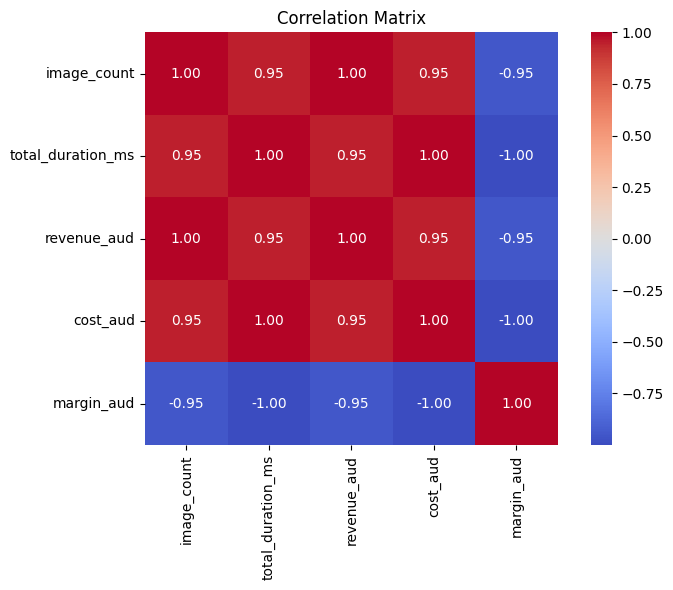

In [57]:
# Compute correlations
corr = geo_summary_df[['image_count', 'total_duration_ms', 'revenue_aud', 'cost_aud', 'margin_aud']].corr()

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


Bivariate Analysis (scatter plot of duration vs revenue)

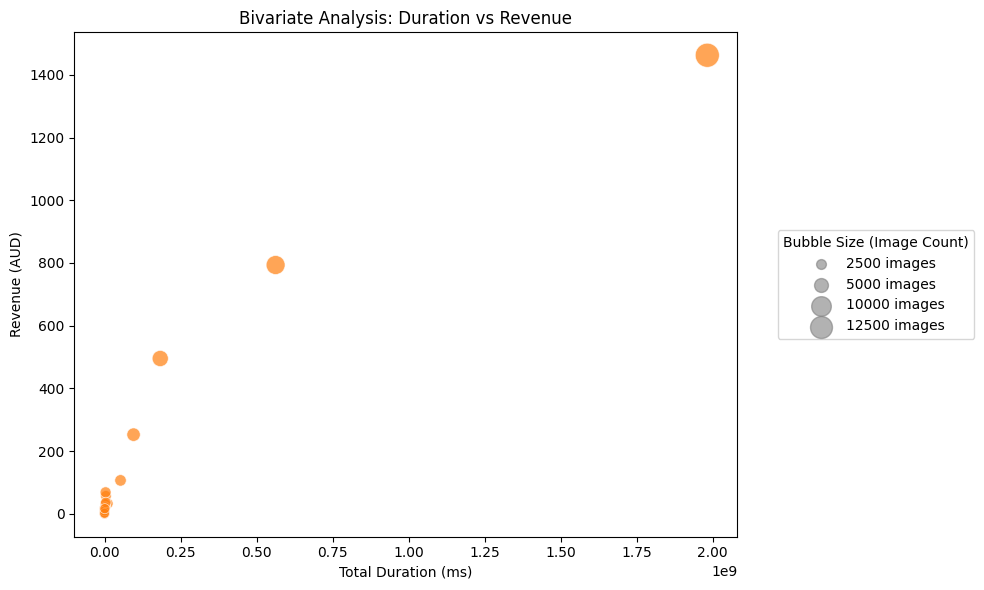

In [58]:


plt.figure(figsize=(10, 6))

# Plot scatter manually
scatter = sns.scatterplot(
    data=geo_summary_df,
    x='total_duration_ms',
    y='revenue_aud',
    hue='state',
    size='image_count',
    sizes=(50, 300),  # control bubble size range
    alpha=0.7,
    legend=False  # hide the default messy legend
)

# Add custom hue legend
handles_h, labels_h = scatter.get_legend_handles_labels()
plt.legend(handles=handles_h[1:], title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a manual legend for bubble size
for size in [2500, 5000, 10000, 12500]:
    plt.scatter([], [], s=(size / 50), label=f'{size} images', color='gray', alpha=0.6)

plt.legend(title='Bubble Size (Image Count)', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.title('Bivariate Analysis: Duration vs Revenue')
plt.xlabel('Total Duration (ms)')
plt.ylabel('Revenue (AUD)')
plt.tight_layout()
plt.show()


Multivariate Analysis (pair plot)

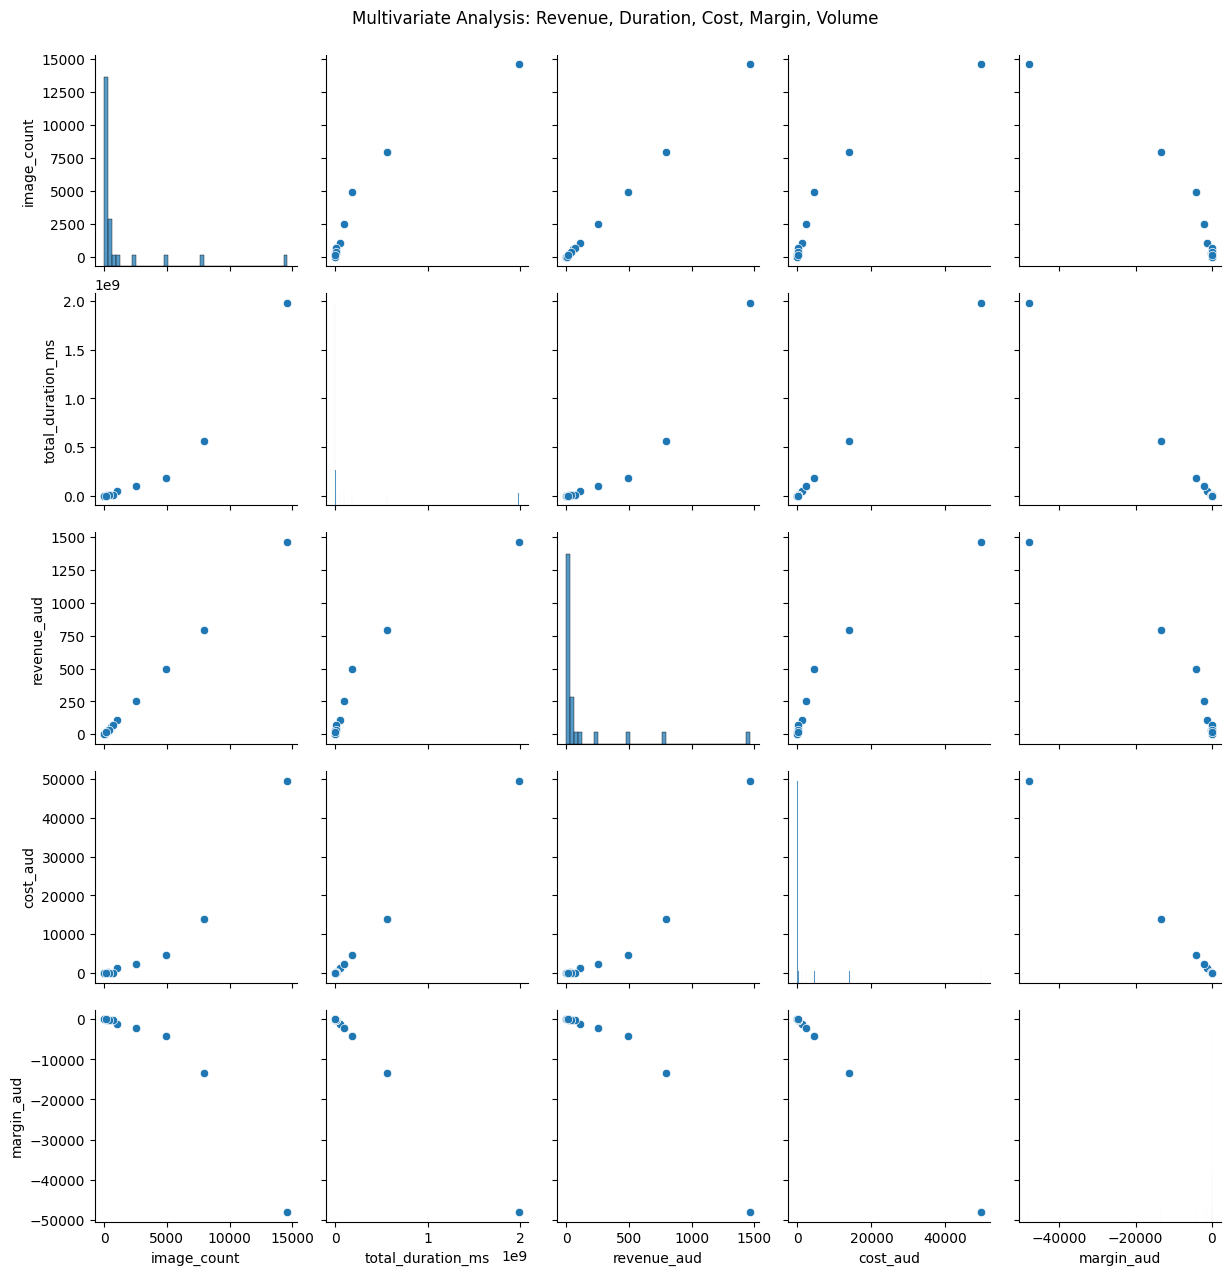

In [59]:
# Select numeric columns for multivariate comparison
pair_df = geo_summary_df[['image_count', 'total_duration_ms', 'revenue_aud', 'cost_aud', 'margin_aud']]


# Create pair plot
sns.pairplot(pair_df)
plt.suptitle('Multivariate Analysis: Revenue, Duration, Cost, Margin, Volume', y=1.02)
plt.show()